<a href="https://colab.research.google.com/github/MaliheDahmardeh/state-house-price-analysis-SM/blob/main/state-house-price-analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Brief description of the dataset
This dataset provides information about the mean home prices across a number of US states and housing types
collected in the period from 30th April 1996 to 31st December 2017 (monthly data). The data are available for 44
states and different house types, in particular 1/2/3/4/5+ bedrooms and single family residence.
#Project steps
The main aim of this project is to perform house price forecasting for the last two years (2016/2017), whose data
should be used as testing set.
Following what we have seen in the laboratory classes, a comprehensive pipeline should be devised, including in
particular:
1. Loading, converting and cleaning of the data;
2. Exploring the dataset with descriptive statistics and (possibly) frequency analysis. Use appropriate graphs to
visualise the data at hand;
3. Focusing on few US states and housing types, describing the time series patterns (visually and numerically);
4. Choosing the appropriate model/models to forecast the data for the specified period for each selected
state/house type. Evaluate the model performance using different metrics. Visualise the results with
appropriate graphs.


#Import

In [145]:
import numpy as np
import pandas as pd
from datetime import datetime
from dateutil import parser
import math
import statistics
from statistics import median
from fractions import Fraction as fr
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
import plotly.express as px
from scipy import stats,signal
from scipy.stats import chi2, chi2_contingency
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

#Dataset Loading ...

In [146]:
!ls

sample_data  State_house_prices_ts.csv


In [147]:
df = pd.read_csv('State_house_prices_ts.csv', sep =',',parse_dates=['Date']).sort_values(by='Date', ascending=True , inplace=False)

In [148]:
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,NaN,79000.0,91500.0,112600.0,135100.0,88300.0
2002,1996-04-30,Louisiana,NaN,NaN,76400.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0
12992,2017-12-31,Mississippi,NaN,NaN,124100.0,221000.0,250400.0,118500.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [149]:
print('columns:', df.columns)
print('')
print('indexes:', df.index)
print('')
print('values:', df.values)

columns: Index(['Date', 'RegionName', 'Price_1bedroom', 'Price_2bedroom',
       'Price_3bedroom', 'Price_4bedroom', 'Price_5BedroomOrMore',
       'Price_SingleFamilyResidence'],
      dtype='object')

indexes: Int64Index([ 1997,  2006,  2005,  2003,  2002,  2001,  2000,  1999,  1998,
             1996,
            ...
            12983, 12984, 12985, 12986, 12987, 12988, 12989, 12990, 12992,
            13006],
           dtype='int64', length=13212)

values: [[Timestamp('1996-04-30 00:00:00') 'Illinois' 83800.0 ... 171700.0
  224000.0 116000.0]
 [Timestamp('1996-04-30 00:00:00') 'Michigan' 66600.0 ... 170200.0
  166500.0 85400.0]
 [Timestamp('1996-04-30 00:00:00') 'Massachusetts' 82900.0 ... 195400.0
  249200.0 144300.0]
 ...
 [Timestamp('2017-12-31 00:00:00') 'Michigan' 101700.0 ... 282900.0
  294100.0 134800.0]
 [Timestamp('2017-12-31 00:00:00') 'Mississippi' nan ... 221000.0
  250400.0 118500.0]
 [Timestamp('2017-12-31 00:00:00') 'Pennsylvania' 118800.0 ... 292100.0
  307000.0 16

In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13212 entries, 1997 to 13006
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         13212 non-null  datetime64[ns]
 1   RegionName                   13212 non-null  object        
 2   Price_1bedroom               10605 non-null  float64       
 3   Price_2bedroom               11745 non-null  float64       
 4   Price_3bedroom               12787 non-null  float64       
 5   Price_4bedroom               12359 non-null  float64       
 6   Price_5BedroomOrMore         11814 non-null  float64       
 7   Price_SingleFamilyResidence  12438 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 929.0+ KB


#Data Cleaning

In [151]:
df.duplicated().sum()  

0

In [152]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 2607
Price_2bedroom                 1467
Price_3bedroom                  425
Price_4bedroom                  853
Price_5BedroomOrMore           1398
Price_SingleFamilyResidence     774
dtype: int64

In [153]:
#check the states that have empty/null row 
a=df.loc[df.isnull().sum(axis=1) > 5]
a.groupby('RegionName').nunique()

,Date,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
RegionName,,,,,,,
Alaska,10,0,0,0,0,0,0
DistrictofColumbia,10,0,0,0,0,0,0
Kansas,64,0,0,0,0,0,0
UnitedStates,95,0,0,0,0,0,0


In [154]:
# drop the states that have lots of null value cause i don't want to change the final result as much as possible
df=df[(df.RegionName != 'UnitedStates')]
df=df[(df.RegionName != 'Kansas')]
df=df[(df.RegionName != 'DistrictofColumbia')]
df=df[(df.RegionName != 'Alaska')]
df=df[(df.RegionName != 'Wyoming')]
df=df[(df.RegionName != 'NorthDakota')]
df=df[(df.RegionName != 'Texas')]
df=df[(df.RegionName != 'Louisiana')]
df=df[(df.RegionName != 'Montana')]

In [155]:
df.isnull().sum()

Date                              0
RegionName                        0
Price_1bedroom                 1485
Price_2bedroom                  522
Price_3bedroom                   16
Price_4bedroom                  216
Price_5BedroomOrMore            449
Price_SingleFamilyResidence     240
dtype: int64

In [156]:
#use median for other null values
df = df.fillna(df.median())
display(df)
display(type(df))
display(df.dtypes)

,Date,RegionName,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
1997,1996-04-30,Illinois,83800.0,92000.0,109300.0,171700.0,224000.0,116000.0
2006,1996-04-30,Michigan,66600.0,76900.0,98200.0,170200.0,166500.0,85400.0
2005,1996-04-30,Massachusetts,82900.0,106600.0,136300.0,195400.0,249200.0,144300.0
2003,1996-04-30,Maine,98400.0,79000.0,91500.0,112600.0,135100.0,88300.0
2001,1996-04-30,Kentucky,49300.0,64600.0,78600.0,126800.0,151100.0,74400.0
...,...,...,...,...,...,...,...,...
12988,2017-12-31,Maryland,160400.0,193400.0,251300.0,378700.0,507700.0,285000.0
12989,2017-12-31,Massachusetts,289300.0,301000.0,368300.0,519100.0,720900.0,392900.0
12990,2017-12-31,Michigan,101700.0,118800.0,158500.0,282900.0,294100.0,134800.0
12992,2017-12-31,Mississippi,98400.0,112300.0,124100.0,221000.0,250400.0,118500.0


pandas.core.frame.DataFrame

Date                           datetime64[ns]
RegionName                             object
Price_1bedroom                        float64
Price_2bedroom                        float64
Price_3bedroom                        float64
Price_4bedroom                        float64
Price_5BedroomOrMore                  float64
Price_SingleFamilyResidence           float64
dtype: object

In [157]:
df.isnull().sum()

Date                           0
RegionName                     0
Price_1bedroom                 0
Price_2bedroom                 0
Price_3bedroom                 0
Price_4bedroom                 0
Price_5BedroomOrMore           0
Price_SingleFamilyResidence    0
dtype: int64

#Functions

In [158]:
def checkAutorcorrelation(resid, lags=36, return_data=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    import statsmodels.api as sm
    import statsmodels.stats.diagnostic as dg
    
    #Ljung-Box
    lb_result = sm.stats.acorr_ljungbox(resid, lags=[lags], return_df=False)
    print("*** Ljung-Box Test [{} lags] ***".format(lags))
    print('Q: ', lb_result[0][0])
    print('p-value: ' , lb_result[1][0])
    if lb_result[1][0]>.05:
        print('Interpretation: the residuals are independently distributed (Ho)')
    else:
        print('Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)')
    
    #Breusch-Godfrey
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    bg_result = dg.acorr_breusch_godfrey(fit, nlags=lags)
    print('\n*** Breusch-Godfrey Test [{} lags] ***'.format(lags))
    print('Lagrange multiplier statistic: ', bg_result[0])
    print('p-value: ', bg_result[1])
    if bg_result[1]>.05:
        print('Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)')
    else:
        print('Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)')
    
    if return_data==True:
        return (lb_result[0][0], lb_result[1][0], bg_result[0], bg_result[1])

In [159]:
def checkNormality(data, return_data=False):
    from scipy.stats import shapiro, jarque_bera, normaltest, skew, kurtosis
    
    #Shapiro-Wilk
    w, p_w = shapiro(data)
    print('*** Shapiro-Wilk Test ***')
    print('W: ', w)
    print('p-value: ' , p_w)
    if p_w > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #Jarque-Bera
    jb, p_jb = jarque_bera(data)
    print('\n*** Jarque-Bera Test ***')
    print('Jarque-Bera JB: ', jb)
    print('p-value: ' , p_jb)
    if p_jb > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')
    
    #D’Agostino-Pearson
    k2, p_k2 = normaltest(data)
    print("\n*** D’Agostino-Pearson Test ***")
    print('k2: ', k2)
    print('p-value: ' , p_k2)
    if p_k2 > .05:
        print('Interpretation: the data was drawn from a normal distribution (Ho)')
    else:
        print('Interpretation: the data was not drawn from a normal distribution (Ha)')

    print('\n----------------------------------------------------------------------')
    print('Skewness: ', skew(data))
    print('Kurtosis : ', kurtosis(data))
    
    if return_data==True:
        return (w, p_w, jb, p_jb, k2, p_k2)

In [160]:
def checkStationarity(data, kpss_type = 'ct', return_data=False, ci=.95):
    alpha = 1-ci
    
    if kpss_type in ['c','ct']:
        import warnings
        warnings.filterwarnings('ignore')
        from statsmodels.tsa.stattools import adfuller
        from statsmodels.tsa.stattools import kpss

        adf_test = adfuller(data,autolag='AIC')
        print('*** ADF Test ***')
        print('ADF Statistic: ', adf_test[0])
        print('p-value: ', adf_test[1])
        if adf_test[1] > alpha:
            print('Interpretation: The time series is non-stationary (Ho)')
        else:
            print('Interpretation: The time series is stationary (Ha)')

        kpss_test = kpss(data, regression=kpss_type, store=True)
        print('\n*** KPSS Test ***')
        print('KPSS Statistic:', kpss_test[0])
        print('p-value: ', kpss_test[1])

        if kpss_type == 'c':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is stationary (Ho)')
            else:
                print('Interpretation: The time series is not stationary (Ha)')
        if kpss_type == 'ct':
            if kpss_test[1] > alpha:
                print('Interpretation: The time series is trend stationary (Ho)')
            else:
                print('Interpretation: The time series is not trend stationary (Ha)')
    else:
        print('KPSS type shuld be c or ct!')
        print('c: checks if time series is stationary \nct: checks if time series is trend stationary')
    
    if return_data==True:
        return (adf_test[0],adf_test[1],kpss_test[0],kpss_test[1])

In [161]:
def autocorrelationPlot(data, lags=30, title=''):
    from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
    import matplotlib.pyplot as plt
    
    fig = plot_acf(data, lags=lags, title='Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    fig = plot_pacf(data, lags=lags, title='Partial Auto-correlation for the first {} lags {}'.format(lags, title));
    fig.set_figwidth(16)
    fig.set_figheight(6)
    plt.show()

In [162]:
def scalelocationPlot(resid, title='', figsize=(16,8)):
    import pandas as pd
    import statsmodels.formula.api as smf
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    #lm
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    #get values
    model_fitted_y = fit.fittedvalues
    model_residuals = fit.resid
    model_norm_residuals = fit.get_influence().resid_studentized_internal
    model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
    
    #plot
    fig = plt.figure(3)
    fig.set_figheight(figsize[1])
    fig.set_figwidth(figsize[0])
    plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
    sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, scatter=False, ci=False, lowess=True,line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8})
    fig.axes[0].set_title('Scale-Location'.format(title), fontsize=14)
    fig.axes[0].set_xlabel('Fitted values')
    fig.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')
    plt.show()

In [163]:
def plotTS(df, column, loess=True, regression=True, figsize=(16,4), title='', xlabel='', ylabel='', theme = 'darkgrid', points_alpha = 0.6, custom_ylim=None):
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.linear_model import LinearRegression
    from statsmodels.nonparametric.smoothers_lowess import lowess


    sns.set_style(theme)
    plt.figure(figsize=figsize)
    plt.scatter(x = df.index, y = df[column], marker='+', alpha=points_alpha, label='Data points')
    
    if loess==True:
        # model fitting
        span, sse = compute_loess_span(df.index,df[column])
        y_loess = lowess(df[column], df.index,  frac=span, it=5, return_sorted = False).T
        #plot
        plt.plot(df.index, y_loess, color='tomato', linewidth=2, label='LOESS (span={})'.format(span))
    if regression==True:
        # model fitting
        model = LinearRegression()
        x_regr = np.arange(len(df[column])).reshape(-1,1)
        model.fit(x_regr,df[column])
        coeff = model.coef_[0]
        y_predicted = model.predict(x_regr)
        #plot
        plt.plot(df.index, y_predicted, color='green', label='Regression line (coeff={})'.format(round(coeff,2)))

    plt.title(title, fontsize=14)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()

In [164]:
def qqPlot(data, title=''):
    fig = sm.qqplot(data, line ='45',fit=True,dist=stats.norm)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.title('Q-Q {}'.format(title))
    plt.show()

In [165]:
def compute_loess_span(x_input,y_input, steps=0.02):
    import numpy as np
    from statsmodels.nonparametric.smoothers_lowess import lowess

    best_span = 0.51
    lowest_SSE = 10e20
    
    for i in np.arange(1,51,steps*100)/100:
        span=i
        y_pred = lowess(y_input,x_input, frac=span, it=5, return_sorted = False).T
        SSE = ((y_input-y_pred)**2).sum()
        if SSE<lowest_SSE:
            best_span = i
            lowest_SSE = SSE
    return (best_span,lowest_SSE)

In [166]:
def checkHomoscedasticity(resid, return_data=False, robust=False, includeWhite=False):
    import pandas as pd
    import statsmodels.formula.api as smf
    from statsmodels.compat import lzip
    import statsmodels.stats.api as sms
    from statsmodels.stats.diagnostic import het_white
    
    resid = pd.DataFrame(resid, columns=['resid'])
    resid['step'] = range(len(resid))
    fit = smf.ols('resid ~ step', data=resid).fit()
    
    if robust==False:
        #Bresuch-Pagan test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog, robust=False)
        print('*** Breusch-Pagan Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')
    else:
        #Koenker test
        lagrange_mult_statistic, p_value_bp, f_value, f_p_value = sms.het_breuschpagan(fit.resid, fit.model.exog , robust=True)
        print('*** Koenker Test ***')
        print('Lagrange multiplier statistic: ', lagrange_mult_statistic)
        print('p-value: ', p_value_bp)
        if p_value_bp > .05:
            print('Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)')

    if includeWhite == True:    
        #White's test
        test_stat, p_value_w, f_stat, f_p_value = het_white(fit.resid,  fit.model.exog)
        print("\n*** White's test ***")
        print('Test statistic: ', test_stat)
        print('p-value: ', p_value_w)
        if p_value_w >.05:
            print('Interpretation: Homoscedasticity is present, residuals are equally scattered (Ho)')
        else:
            print('Interpretation: Heteroscedasticity is present, residuals are not equally scattered (Ha)')
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp,test_stat, p_value_w)
    else:
        if return_data==True:
            return (lagrange_mult_statistic,p_value_bp)

#Data manipulation

In [167]:
#name and number of states in the data set 
print('Total number of States :',df['RegionName'].nunique())
print('-------------')
print('Name of the States :',df['RegionName'].unique(),sep='\n')

Total number of States : 43
-------------
Name of the States :
['Illinois' 'Michigan' 'Massachusetts' 'Maine' 'Kentucky' 'Iowa' 'Indiana'
 'Idaho' 'Hawaii' 'Georgia' 'Florida' 'Delaware' 'Connecticut' 'Colorado'
 'California' 'Arkansas' 'Arizona' 'Alabama' 'Minnesota' 'Mississippi'
 'Maryland' 'Nebraska' 'Wisconsin' 'WestVirginia' 'Washington' 'Virginia'
 'Utah' 'Missouri' 'SouthCarolina' 'RhodeIsland' 'Pennsylvania'
 'Tennessee' 'Nevada' 'Oklahoma' 'Ohio' 'NorthCarolina' 'NewYork'
 'NewMexico' 'NewJersey' 'NewHampshire' 'Oregon' 'Vermont' 'SouthDakota']


In [168]:
df.describe()

,Price_1bedroom,Price_2bedroom,Price_3bedroom,Price_4bedroom,Price_5BedroomOrMore,Price_SingleFamilyResidence
count,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000,11221.000000
mean,112072.239551,129490.794047,164903.110240,240475.073523,308957.583994,170679.734427
std,52040.042620,63570.714790,77210.229494,97358.963352,133201.736586,89694.974051
min,30900.000000,32800.000000,49600.000000,64700.000000,68600.000000,37900.000000
25%,77400.000000,86900.000000,116500.000000,175500.000000,217000.000000,114300.000000
50%,98400.000000,112300.000000,141000.000000,218200.000000,283750.000000,145100.000000
75%,135200.000000,160700.000000,202200.000000,278900.000000,356300.000000,210200.000000
max,374500.000000,463000.000000,639700.000000,804900.000000,933900.000000,737500.000000


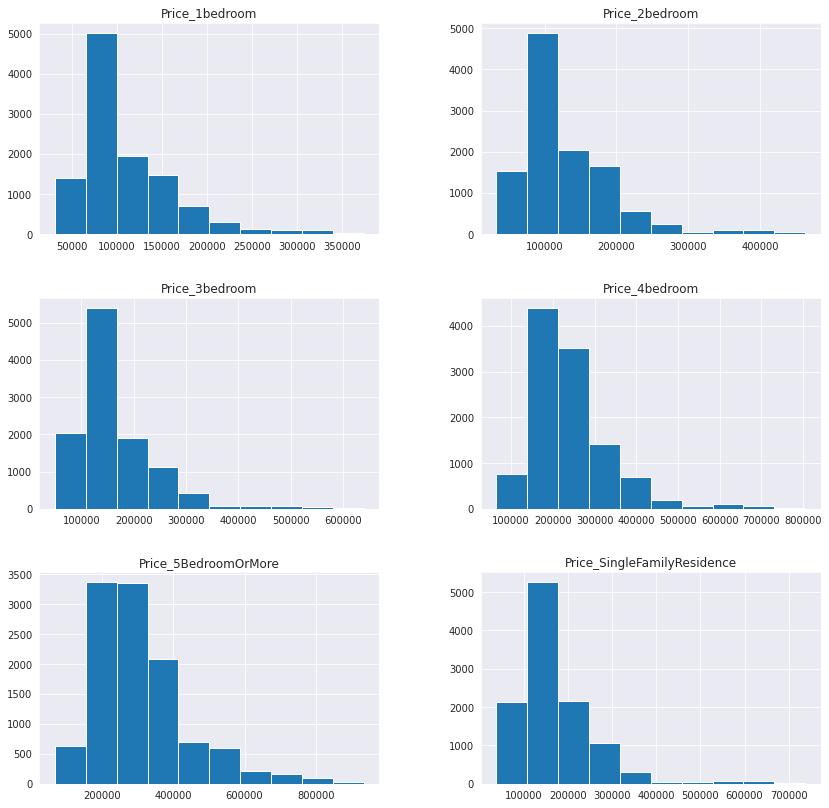

In [169]:
#histogram for different type of houses
df_hist = df.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(14,14));

In [170]:
#creat a pivot table of states regarding the date and total price of all type of houses
df['houseprice']=df['Price_1bedroom']+df['Price_2bedroom']+df['Price_3bedroom']+df['Price_4bedroom']+df['Price_5BedroomOrMore']+df['Price_SingleFamilyResidence']
house_price_by_region= pd.pivot_table(data=df, index='Date', columns='RegionName',values='houseprice')

In [171]:
display(house_price_by_region)
display(type(house_price_by_region))
display(house_price_by_region.dtypes)
display(house_price_by_region.index)

RegionName,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Hawaii,...,RhodeIsland,SouthCarolina,SouthDakota,Tennessee,Utah,Vermont,Virginia,Washington,WestVirginia,Wisconsin
Date,,,,,,,,,,,,,,,,,,,,,
1996-04-30,620400.0,668100.0,569900.0,991400.0,826900.0,927700.0,723100.0,625500.0,682500.0,1482200.0,...,758500.0,719250.0,NaN,593200.0,753500.0,NaN,766000.0,837300.0,431500.0,939350.0
1996-05-31,614900.0,668100.0,570700.0,988900.0,828800.0,926000.0,724200.0,626400.0,683200.0,1471400.0,...,755900.0,718050.0,524300.0,595100.0,755000.0,807200.0,766400.0,837200.0,434800.0,938750.0
1996-06-30,613100.0,669200.0,572600.0,984400.0,829600.0,926300.0,725800.0,625600.0,683400.0,1458300.0,...,753000.0,717850.0,522200.0,597400.0,757000.0,815800.0,765600.0,836900.0,439100.0,937750.0
1996-07-31,612600.0,670000.0,572900.0,980700.0,830400.0,927200.0,726400.0,624300.0,683300.0,1443500.0,...,749500.0,718150.0,520000.0,599400.0,760000.0,821900.0,764500.0,837100.0,443100.0,936650.0
1996-08-31,611800.0,670900.0,573100.0,977800.0,831300.0,926400.0,726800.0,623800.0,682800.0,1429000.0,...,746200.0,717650.0,519600.0,601600.0,764400.0,822000.0,764100.0,837400.0,445500.0,936150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-31,1007300.0,1446500.0,1050700.0,3170600.0,2119200.0,1725200.0,1436800.0,1482200.0,1197300.0,3868900.0,...,1778600.0,1046450.0,1091100.0,1203700.0,1415800.0,1573200.0,1723900.0,2240900.0,763000.0,1053200.0
2017-09-30,1011800.0,1455300.0,1055200.0,3188700.0,2129000.0,1731800.0,1443700.0,1490900.0,1204300.0,3885100.0,...,1792400.0,1050350.0,1098300.0,1211500.0,1423600.0,1576300.0,1728900.0,2259300.0,764900.0,1058900.0
2017-10-31,1013700.0,1465100.0,1059300.0,3209600.0,2139900.0,1736500.0,1455900.0,1499300.0,1209200.0,3906800.0,...,1807000.0,1055350.0,1103900.0,1218800.0,1431900.0,1569600.0,1732100.0,2278900.0,766600.0,1063400.0


pandas.core.frame.DataFrame

RegionName
Alabama          float64
Arizona          float64
Arkansas         float64
California       float64
Colorado         float64
Connecticut      float64
Delaware         float64
Florida          float64
Georgia          float64
Hawaii           float64
Idaho            float64
Illinois         float64
Indiana          float64
Iowa             float64
Kentucky         float64
Maine            float64
Maryland         float64
Massachusetts    float64
Michigan         float64
Minnesota        float64
Mississippi      float64
Missouri         float64
Nebraska         float64
Nevada           float64
NewHampshire     float64
NewJersey        float64
NewMexico        float64
NewYork          float64
NorthCarolina    float64
Ohio             float64
Oklahoma         float64
Oregon           float64
Pennsylvania     float64
RhodeIsland      float64
SouthCarolina    float64
SouthDakota      float64
Tennessee        float64
Utah             float64
Vermont          float64
Virginia      

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq=None)

In [172]:
#looking for null value in the table,we drop some states that had lots of null values before
house_price_by_region.isnull().sum()

RegionName
Alabama          0
Arizona          0
Arkansas         0
California       0
Colorado         0
Connecticut      0
Delaware         0
Florida          0
Georgia          0
Hawaii           0
Idaho            0
Illinois         0
Indiana          0
Iowa             0
Kentucky         0
Maine            0
Maryland         0
Massachusetts    0
Michigan         0
Minnesota        0
Mississippi      0
Missouri         0
Nebraska         0
Nevada           0
NewHampshire     0
NewJersey        0
NewMexico        0
NewYork          0
NorthCarolina    0
Ohio             0
Oklahoma         0
Oregon           0
Pennsylvania     0
RhodeIsland      0
SouthCarolina    0
SouthDakota      1
Tennessee        0
Utah             0
Vermont          1
Virginia         0
Washington       0
WestVirginia     0
Wisconsin        0
dtype: int64

In [173]:
#filling two null values with the value of their previous month
house_price_by_region = house_price_by_region.fillna(method='bfill')

In [174]:
# Converting the index as date with monthly frequency
house_price_by_region.index = pd.to_datetime(house_price_by_region.index)
house_price_by_region= house_price_by_region.asfreq('M')
display(house_price_by_region.index)

DatetimeIndex(['1996-04-30', '1996-05-31', '1996-06-30', '1996-07-31',
               '1996-08-31', '1996-09-30', '1996-10-31', '1996-11-30',
               '1996-12-31', '1997-01-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='Date', length=261, freq='M')

#Data exploration

#How is the trend of the price of houses in the united states during the years:

In [175]:
#calculate total price in all states for every year(million dollar)
price_total = house_price_by_region.sum(axis=1)
price_total_by_year = price_total.resample('Y').sum()
price_total_by_year.index = price_total_by_year.index.year
price_total_by_year = price_total_by_year/1000000
display(price_total_by_year)

Date
1996    276.69735
1997    377.02335
1998    391.25610
1999    411.73630
2000    440.28180
2001    473.00280
2002    506.54440
2003    549.19970
2004    605.87210
2005    678.78430
2006    724.46510
2007    725.75340
2008    689.13150
2009    645.55710
2010    615.11535
2011    587.91470
2012    583.34560
2013    611.71230
2014    640.29170
2015    666.72560
2016    701.16870
2017    741.09000
dtype: float64

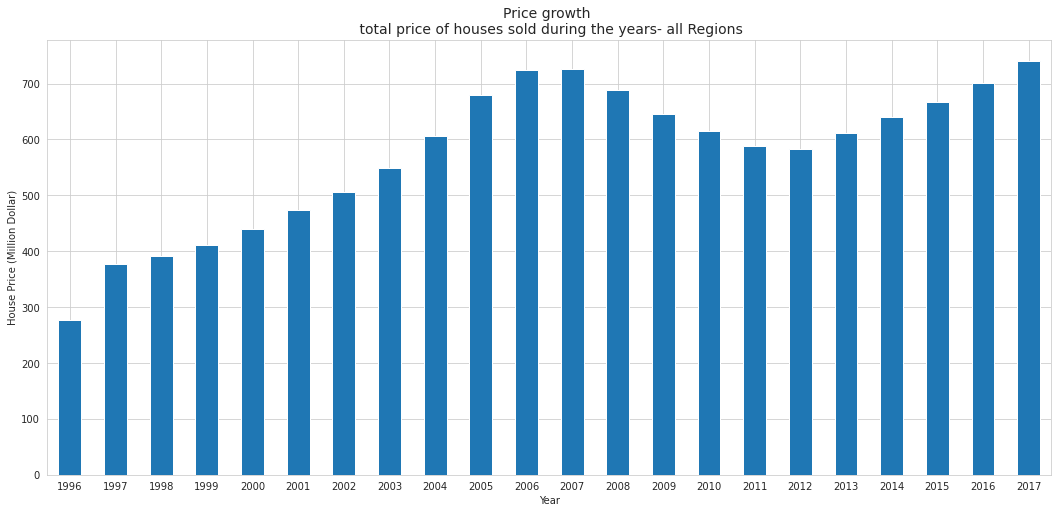

In [176]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_year.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='Year')
plt.title('Price growth \n total price of houses sold during the years- all Regions', fontsize=14)
plt.show()

#In what States the house price is higher and how is its trend

In [177]:
#finding the top 10 most expensive states
price_total_by_Region = house_price_by_region.sum(axis=0)
price_total_by_regions = pd.Series(price_total_by_Region , name='RegionName')
price_total_by_regions_top10 = price_total_by_Region.sort_values(ascending=False).head(10)
display(price_total_by_regions_top10)

RegionName
Hawaii           671738100.0
California       567633000.0
Massachusetts    493029300.0
NewJersey        431455000.0
Connecticut      418604300.0
Washington       385042700.0
Maryland         382427500.0
RhodeIsland      372439900.0
Virginia         363337400.0
Colorado         358761100.0
dtype: float64

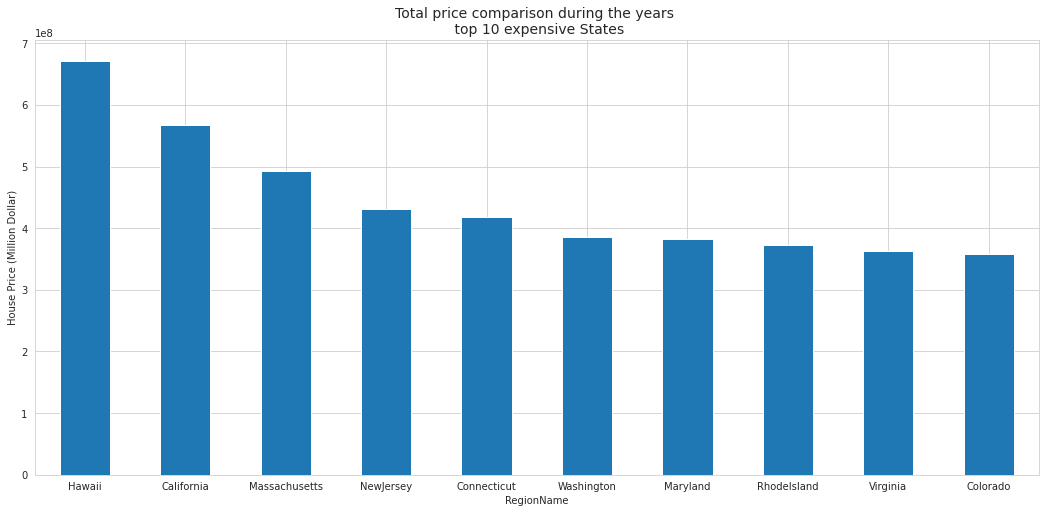

In [178]:
plt.figure(figsize=(18,8))
sns.set_style('whitegrid')
price_total_by_regions_top10.plot(kind='bar', rot=0, ylabel='House Price (Million Dollar)', xlabel='RegionName')
plt.title('Total price comparison during the years \n top 10 expensive States', fontsize=14)
plt.show()

#compare total price of houses in different states

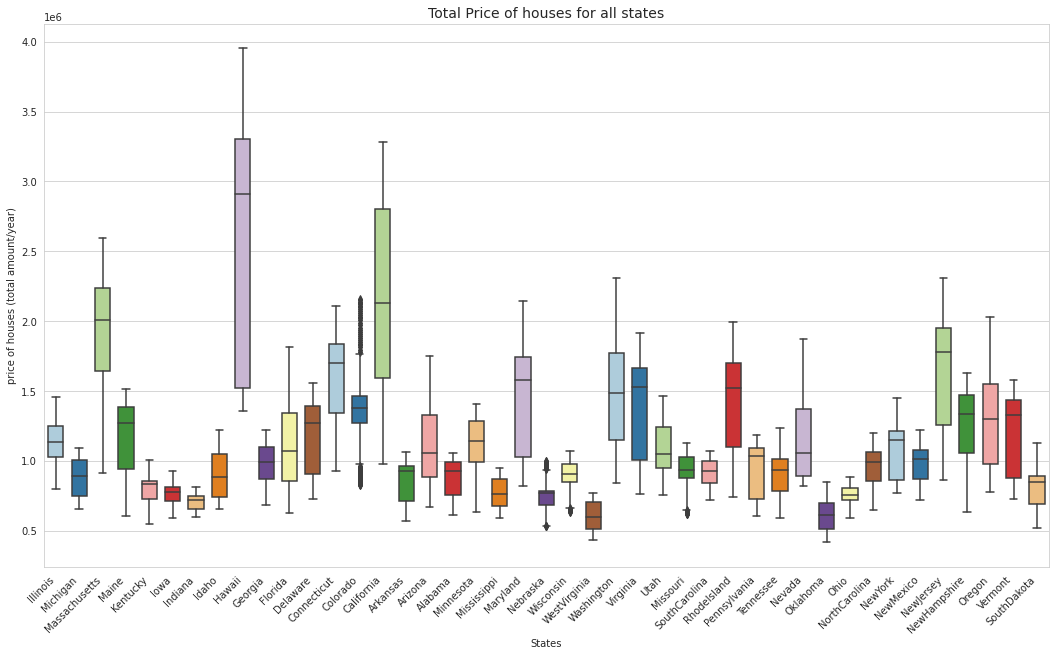

In [179]:
#check the total price of houses for all states
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(x="RegionName", y="houseprice", data=df, palette='Paired', width=0.65)
plt.title('Total Price of houses for all states', fontsize=14)
plt.xlabel('States')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('price of houses (total amount/year)')
plt.show()

In [180]:
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
import plotly.graph_objs as go
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

# define our data for plotting
data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = price_total_by_regions.index, # location (states)
        z = price_total_by_regions.values.astype(float), # Home value
        locationmode = 'USA-states', # let's define the location mode to USA_states
        text = 'house price in different states',
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "House value")
        ) ]

layout = dict(
        title = 'the value of all type of Houses in different states<br>',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
fig = dict( data=data, layout=layout )
# let's plot
iplot( fig, filename='d3-cloropleth-map' )

#How is the price in different months

In [181]:
#extract months and years of the date
price_groupby = df[['Date','RegionName','houseprice']].groupby(['Date','RegionName']).sum()
price_groupby['year'] = (price_groupby.index).to_series().map(lambda x : x[0].year)
price_groupby['month'] = (price_groupby.index).to_series().map(lambda x : x[0].month)
display(price_groupby)

houseprice  year  month
Date       RegionName                           
1996-04-30 Alabama         620400.0  1996      4
           Arizona         668100.0  1996      4
           Arkansas        569900.0  1996      4
           California      991400.0  1996      4
           Colorado        826900.0  1996      4
...                             ...   ...    ...
2017-12-31 Vermont        1538300.0  2017     12
           Virginia       1729000.0  2017     12
           Washington     2311900.0  2017     12
           WestVirginia    764800.0  2017     12
           Wisconsin      1069900.0  2017     12

[11221 rows x 3 columns]

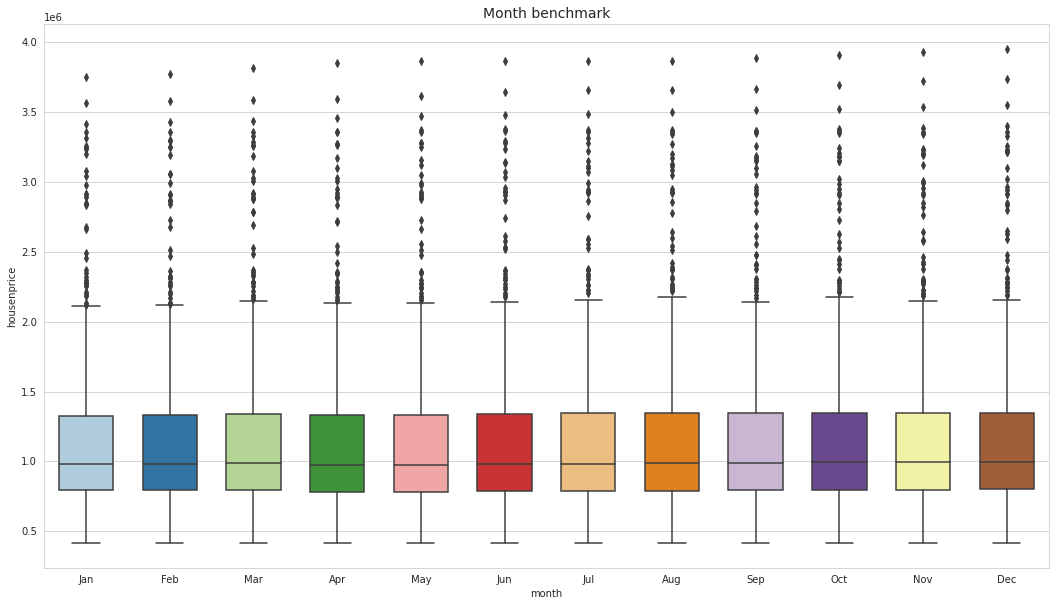

In [182]:
fig = plt.figure(figsize=(18,10))
ax  = fig.add_subplot()
sns.set_style('whitegrid')
sns.boxplot(data=price_groupby, x='month', y='houseprice', palette='Paired', width=0.65)
plt.title('Month benchmark', fontsize=14)
plt.ylabel('housenprice')
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.show()

#compare of price between different type of houses and how is the trend

In [183]:
#compare of price between different type of houses
d=df.groupby('Date').sum()[['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence']]
d.index = pd.to_datetime(d.index)
d= d.asfreq('M')
pr = d.resample('Y').sum()
pr.index = pr.index.year
pr.reset_index(level=0, inplace=True)

In [184]:
fig = px.line(pr,x='Date',y=['Price_1bedroom','Price_2bedroom','Price_3bedroom','Price_4bedroom' ,'Price_5BedroomOrMore' ,'Price_SingleFamilyResidence'])
fig.update_layout(title='<b>price growth of different type of Houses in USA<b> ',plot_bgcolor = 'whitesmoke')
fig.show()

#Discriptive Statistics-Time series Analysis

In [185]:
descriptive_stat = house_price_by_region.describe().T

Q1 = house_price_by_region.quantile(0.25)
Q3 = house_price_by_region.quantile(0.75)
IQR = Q3 - Q1

outlier_lower_count = (house_price_by_region < (Q1 - 1.5 * IQR)).sum()
outlier_upper_count = (house_price_by_region > (Q3 + 1.5 * IQR)).sum()
outlier_total_count = outlier_lower_count + outlier_upper_count

descriptive_stat['range']=descriptive_stat['max']-descriptive_stat['min']
descriptive_stat['IQR']=descriptive_stat['75%']-descriptive_stat['25%']
descriptive_stat['outlier_lower_count'] = outlier_lower_count
descriptive_stat['outlier_upper_count'] = outlier_upper_count
descriptive_stat['outlier_total_count'] = outlier_total_count

display(round(descriptive_stat,2))

,count,mean,std,min,25%,50%,75%,max,range,IQR,outlier_lower_count,outlier_upper_count,outlier_total_count
RegionName,,,,,,,,,,,,,
Alabama,261.0,875070.50,135617.28,611800.0,757600.0,926400.0,988400.0,1051900.0,440100.0,230800.0,0,0,0
Arizona,261.0,1116487.36,302705.38,668100.0,883700.0,1056600.0,1328800.0,1748900.0,1080800.0,445100.0,0,0,0
Arkansas,261.0,850105.36,145051.02,569900.0,714100.0,923700.0,963000.0,1063800.0,493900.0,248900.0,0,0,0
California,261.0,2174839.08,718250.34,976200.0,1593500.0,2130200.0,2801600.0,3280900.0,2304700.0,1208100.0,0,0,0
Colorado,261.0,1374563.60,301618.45,826900.0,1268400.0,1377000.0,1466700.0,2158900.0,1332000.0,198300.0,35,29,64
Connecticut,261.0,1603847.89,353687.60,924900.0,1343000.0,1699200.0,1834300.0,2106000.0,1181100.0,491300.0,0,0,0
Delaware,261.0,1181806.51,269770.23,723100.0,906200.0,1268900.0,1394200.0,1554000.0,830900.0,488000.0,0,0,0
Florida,261.0,1110827.20,331935.39,623100.0,852000.0,1067700.0,1339100.0,1811500.0,1188400.0,487100.0,0,0,0
Georgia,261.0,978277.78,146564.79,682500.0,868500.0,991800.0,1099800.0,1218300.0,535800.0,231300.0,0,0,0


In [186]:
Hawaii_ts = pd.DataFrame(house_price_by_region['Hawaii'])

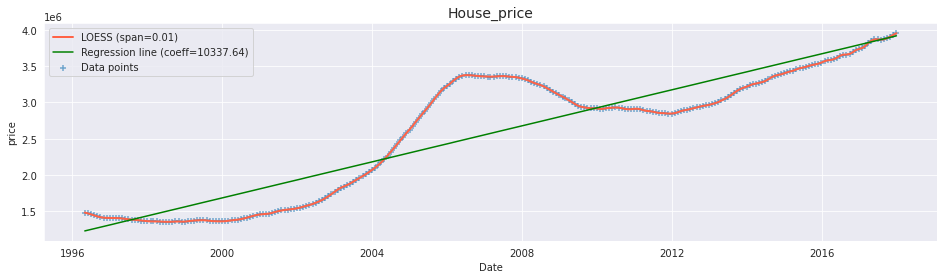

In [187]:
plotTS(Hawaii_ts, column='Hawaii',figsize=(16,4), title='House_price', xlabel='Date', ylabel='price')

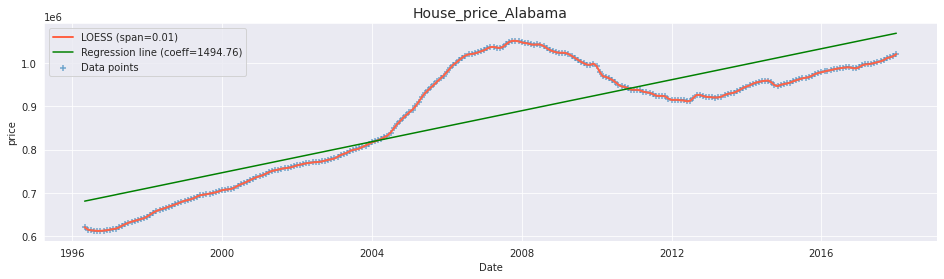

In [188]:
Alabama_ts = pd.DataFrame(house_price_by_region['Alabama'])
plotTS(Alabama_ts, column='Alabama', title='House_price_Alabama', xlabel='Date', ylabel='price')

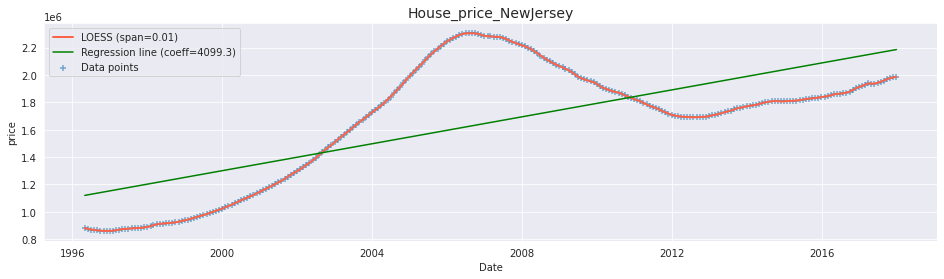

In [189]:
NewJersey_ts = pd.DataFrame(house_price_by_region['NewJersey'])
plotTS(NewJersey_ts, column='NewJersey', title='House_price_NewJersey', xlabel='Date', ylabel='price')

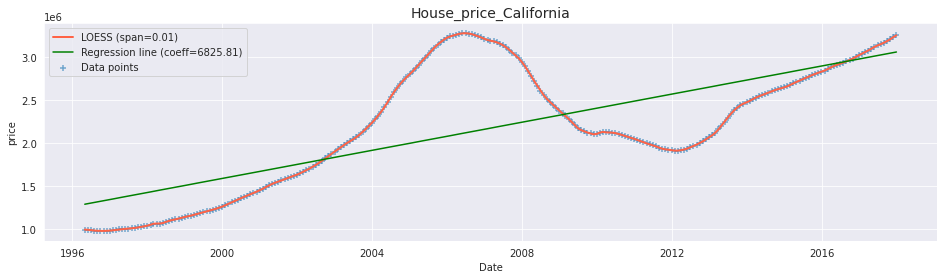

In [190]:
California_ts = pd.DataFrame(house_price_by_region['California'])
plotTS(California_ts, column='California', title='House_price_California', xlabel='Date', ylabel='price')

#Analysis of State,Hawaii

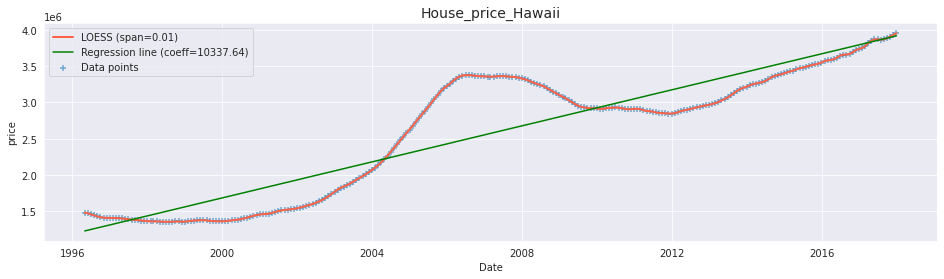

In [191]:
plotTS(Hawaii_ts, column='Hawaii',figsize=(16,4), title='House_price_Hawaii', xlabel='Date', ylabel='price')

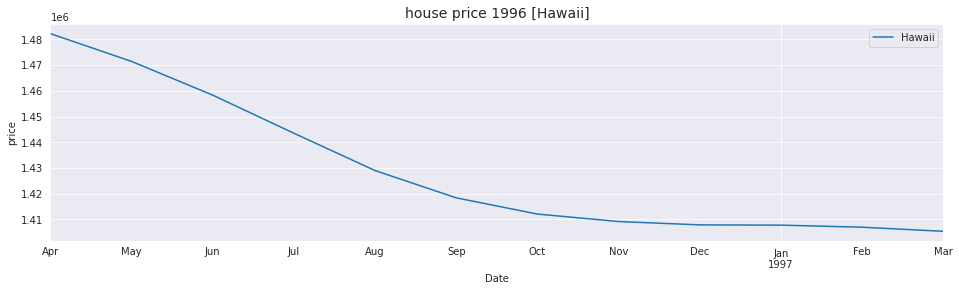

In [192]:
fig = Hawaii_ts[0:12].plot(figsize=(16,4), title='house price 1996 [Hawaii]')
fig.axes.title.set_size(14)
plt.xlabel('Date')
plt.ylabel('price')
plt.show()

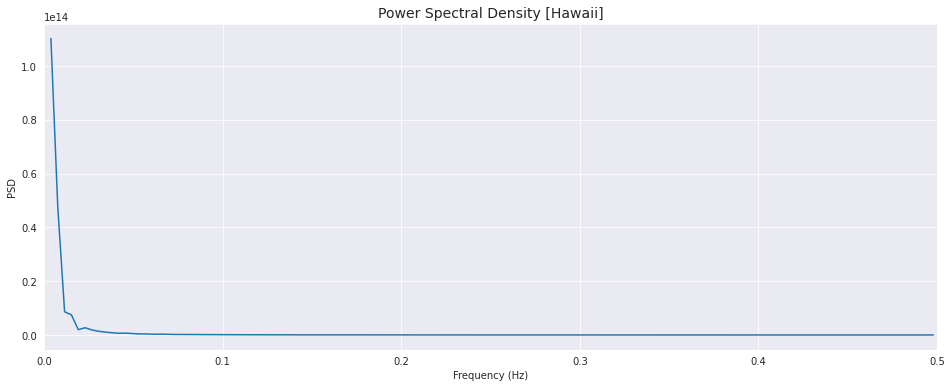

,Freq,Power,Period (year)


In [193]:
#check frequency 
Fs = 1
f_per, Pxx_per = signal.periodogram(Hawaii_ts['Hawaii'],Fs,window=None,return_onesided=True,scaling='density')
sns.set_style('darkgrid')
plt.figure(figsize=(16,6))
plt.title('Power Spectral Density [Hawaii]', fontsize=14)
plt.plot(f_per[1:],Pxx_per[1:])
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')

f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
peaks = signal.find_peaks(Pxx_per[ f_per >= 0], prominence=np.quantile(Pxx_per, 0.99))[0]
peaks_freq = f_per[peaks]
peaks_power = Pxx_per[peaks]
plt.plot(peaks_freq, peaks_power, 'ro')
plt.xlim(0,0.5)
plt.show()

data = {'Freq':peaks_freq, 'Power':peaks_power}
df_PSD = pd.DataFrame(data)
df_PSD['Period (year)'] = 1/df_PSD['Freq']
display(df_PSD)

#Stationarity

In [194]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='c')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 1.3861937312012766
p-value:  0.01
Interpretation: The time series is not stationary (Ha)


In [195]:
checkStationarity(Hawaii_ts['Hawaii'], kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -0.9812680163361206
p-value:  0.7600349062134676
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.19044060424763584
p-value:  0.019584773407136557
Interpretation: The time series is not trend stationary (Ha)


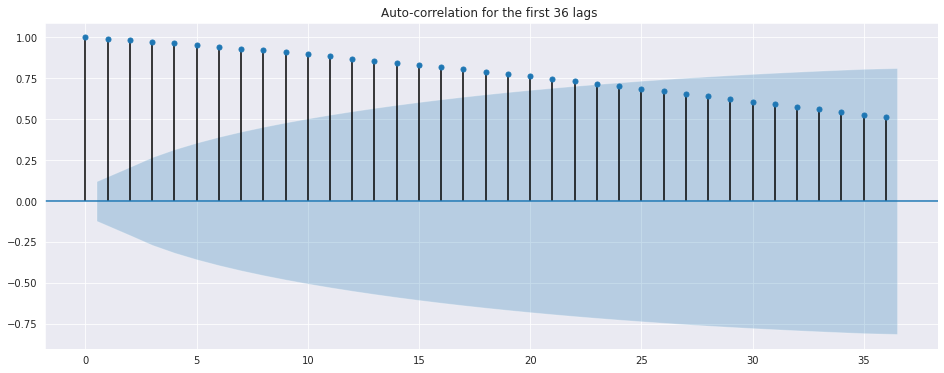

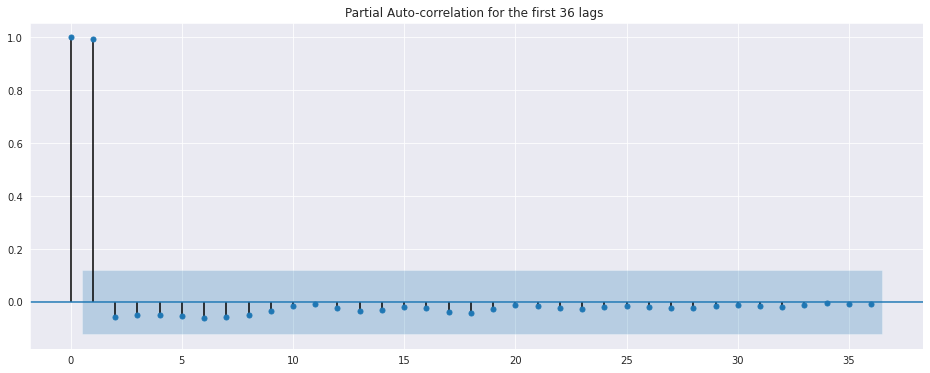

*** Ljung-Box Test [36 lags] ***
Q:  6206.401860763039
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  260.318224281947
p-value:  8.469062156007633e-36
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [196]:
autocorrelationPlot(Hawaii_ts['Hawaii'], lags=36)
checkAutorcorrelation(Hawaii_ts['Hawaii'].values, lags=36)

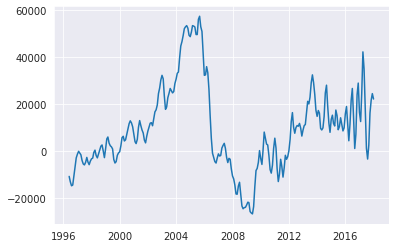

In [197]:
Hawaii_ts['diff_o1'] = np.append([np.nan],np.diff(Hawaii_ts['Hawaii'], n=1))
difference1 = Hawaii_ts['diff_o1'].dropna()
plt.plot(difference1)

In [198]:
checkStationarity(difference1, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -2.302344626368526
p-value:  0.1712128979054191
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.1320144533985329
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [199]:
checkStationarity(difference1, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -2.302344626368526
p-value:  0.1712128979054191
Interpretation: The time series is non-stationary (Ho)

*** KPSS Test ***
KPSS Statistic: 0.13293344976959656
p-value:  0.07419731524148784
Interpretation: The time series is trend stationary (Ho)


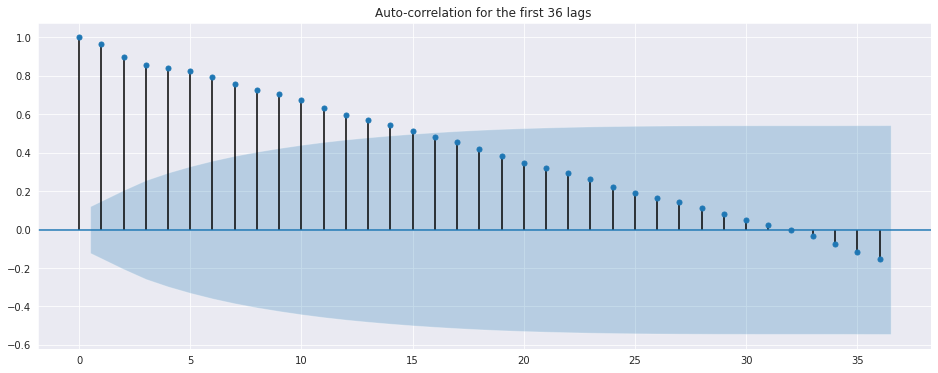

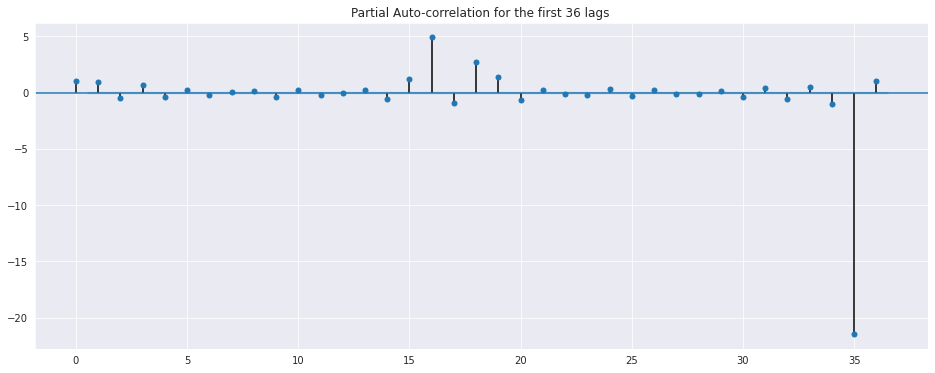

*** Ljung-Box Test [36 lags] ***
Q:  2579.623313049075
p-value:  0.0
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  252.0559512113782
p-value:  3.0615158708764556e-34
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [200]:

autocorrelationPlot(difference1, lags=36)
checkAutorcorrelation(difference1.values, lags=36)

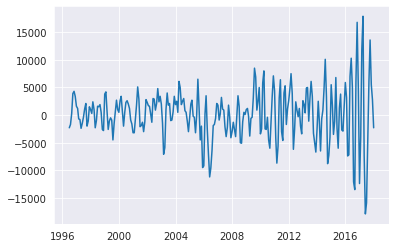

In [201]:
Hawaii_ts['diff_o2'] = np.append([np.nan] * 2,np.diff(Hawaii_ts['Hawaii'], n=2))
difference2 = Hawaii_ts['diff_o2'].dropna()
plt.plot(difference2)

In [202]:
checkStationarity(difference2, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -4.780085694720618
p-value:  5.936280802869571e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.07721783263798201
p-value:  0.1
Interpretation: The time series is stationary (Ho)


In [223]:
checkStationarity(difference2, kpss_type='ct')

*** ADF Test ***
ADF Statistic:  -4.780085694720618
p-value:  5.936280802869571e-05
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.07393468305540667
p-value:  0.1
Interpretation: The time series is trend stationary (Ho)


#decomposition

In [203]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [249]:
#extracting components
sdecom = seasonal_decompose(Hawaii_ts['Hawaii'], model='additive', period=12, two_sided=True)

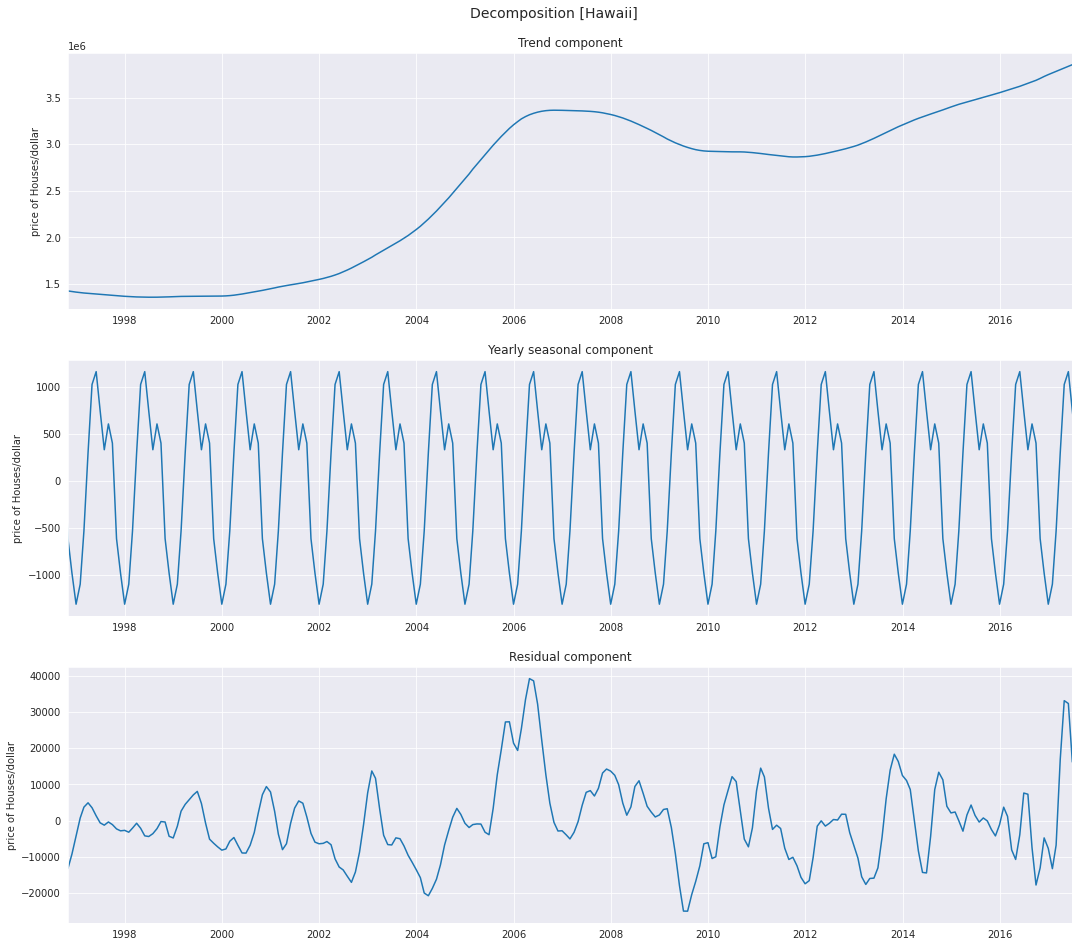

In [250]:
f, axes = plt.subplots(3,1,figsize=(18,16))
plt.suptitle('Decomposition [Hawaii]', y=0.92, fontsize=14)

#plotting trend component
axes[0].plot(sdecom.trend)
axes[0].set_title('Trend component', fontdict={'fontsize': 12})

#plotting yearly seasonal component
axes[1].plot(sdecom.seasonal)
axes[1].set_title('Yearly seasonal component', fontdict={'fontsize': 12})

#plotting residual of decomposition
axes[2].plot(sdecom.resid)
axes[2].set_title('Residual component', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('price of Houses/dollar')
    a.set_xlim(sdecom.trend.dropna().index[0], sdecom.trend.dropna().index[-1])

#showing chart
plt.show()

#decomposition-residual

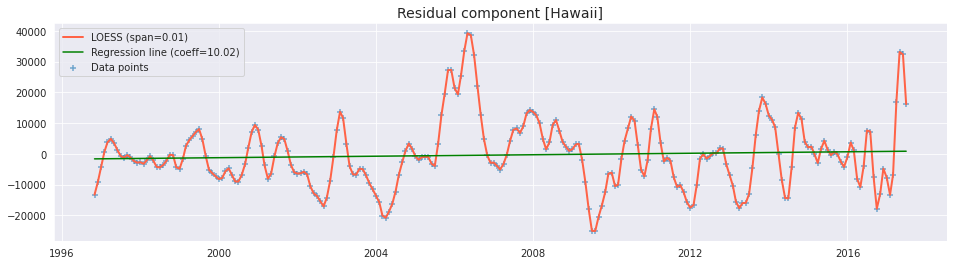

In [206]:
decomp_residuals = pd.DataFrame(sdecom.resid.dropna())
plotTS(decomp_residuals, column='resid', figsize=(16,4), title='Residual component [Hawaii]')

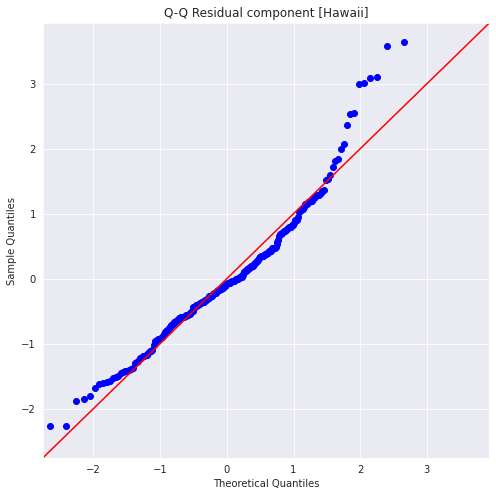

*** Shapiro-Wilk Test ***
W:  0.9566412568092346
p-value:  8.384466809729929e-07
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  54.63656100191381
p-value:  1.3671286325234178e-12
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  [35.43434208]
p-value:  [2.0208328e-08]
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  [0.83630829]
Kurtosis :  [1.57115509]


In [207]:
qqPlot(decomp_residuals['resid'], title='Residual component [Hawaii]')
checkNormality(decomp_residuals)

In [208]:
checkStationarity(decomp_residuals, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -3.905664464371959
p-value:  0.0019935530025647456
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.0879055814389594
p-value:  0.1
Interpretation: The time series is stationary (Ho)


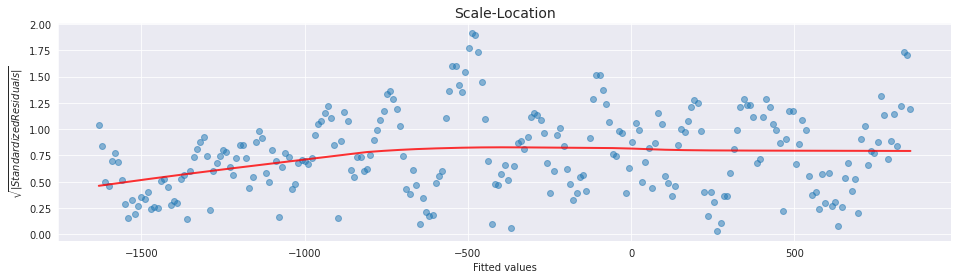

*** Koenker Test ***
Lagrange multiplier statistic:  4.6619461750298035
p-value:  0.030838218215414177
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [209]:
scalelocationPlot(decomp_residuals['resid'], figsize=(16,4))
checkHomoscedasticity(decomp_residuals, robust=True)

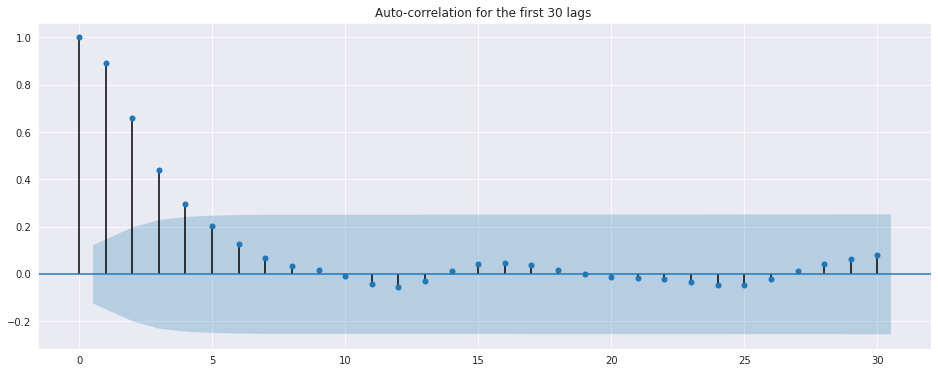

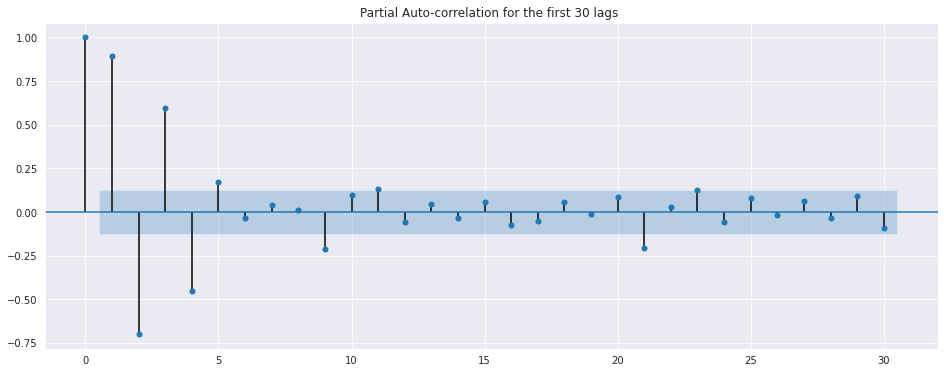

*** Ljung-Box Test [30 lags] ***
Q:  407.04476763148034
p-value:  1.0526845706455671e-67
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [30 lags] ***
Lagrange multiplier statistic:  232.921038338111
p-value:  2.9039471382245547e-33
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [210]:
autocorrelationPlot(decomp_residuals['resid'], lags=30)
checkAutorcorrelation(decomp_residuals, lags=30)

#**Models**

In [211]:
# Train and test 
data_train = Hawaii_ts[:-24]['Hawaii'] 
data_test = Hawaii_ts[-24:]['Hawaii']

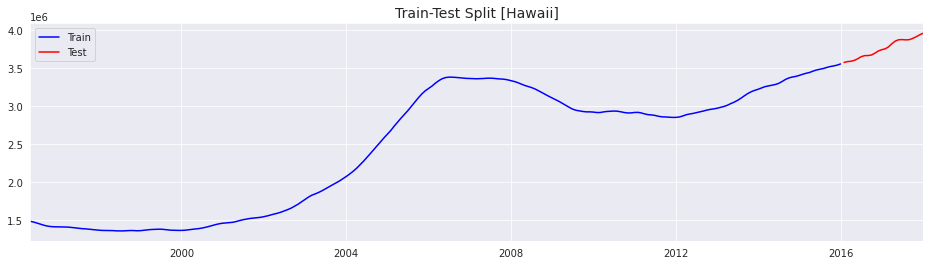

In [212]:
plt.figure(figsize=(16,4))
plt.plot(data_train, color='blue', label='Train')
plt.plot(data_test, color='red', label='Test')
plt.xlim(data_train.index[0],data_test.index[-1])
plt.title('Train-Test Split [Hawaii]', fontsize=14)
plt.legend()
plt.show()

#ARIMA

In [ ]:
!pip install pmdarima

In [214]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

Performing stepwise search to minimize aicc
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AICC=5312.055, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AICC=5311.118, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AICC=5311.202, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AICC=5357.663, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AICC=5339.941, Time=0.34 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AICC=5305.580, Time=0.72 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AICC=10173.526, Time=0.92 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=0.46 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AICC=5311.707, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AICC=inf, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AICC=inf, Time=0.23 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.306 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  23

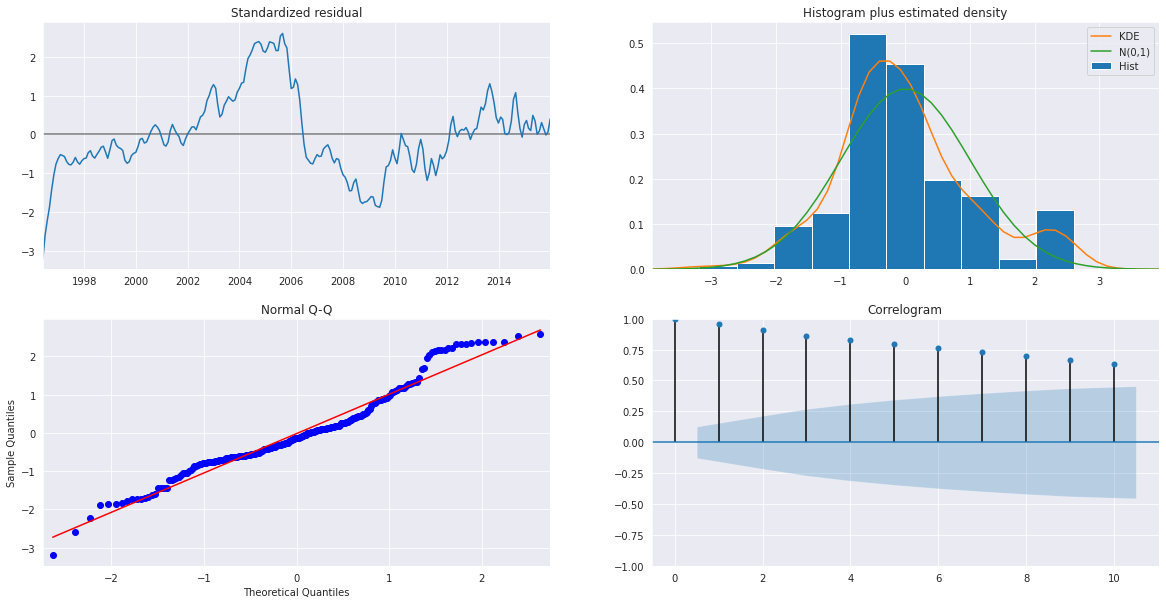

In [215]:
# Auto-ARIMA 

arima_model =  auto_arima(data_train,start_p=0, d=1, start_q=0, 
                          max_p=6, max_q=6,start_P=0, seasonal=False, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,information_criterion='aicc')
print(arima_model.summary())
arima_model.plot_diagnostics(figsize=(20, 10));

                               SARIMAX Results                                
Dep. Variable:                 Hawaii   No. Observations:                  237
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -2237.727
Date:                Fri, 03 Feb 2023   AIC                           4483.455
Time:                        22:55:22   BIC                           4497.276
Sample:                    04-30-1996   HQIC                          4489.027
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    285.2856    300.997      0.948      0.343    -304.659     875.230
ar.L1          0.9779      0.014     71.866      0.000       0.951       1.005
ma.L1          0.1034      0.010     10.285      0.0

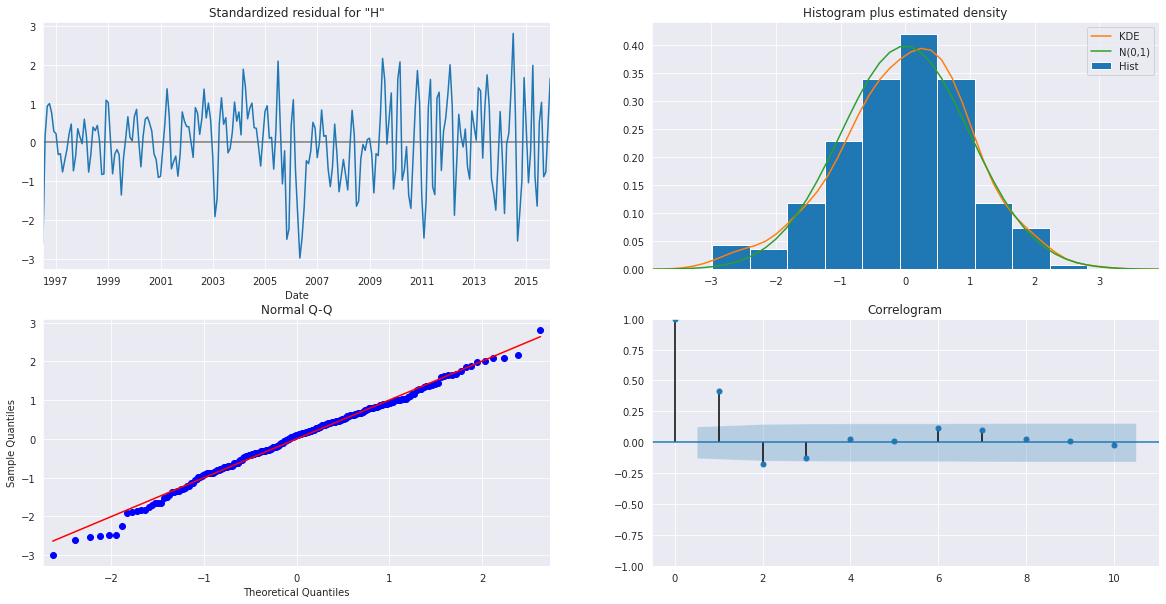

In [216]:
# Fit the model with the automatically selected parameters - ARIMA(1,1,0)(0,1,0)[12]
[p,d,q] = [1,1,1] # stepwise_model.order
[P,D,Q,S] = [0,0,0,12] # stepwise_model.seasonal_order
model_ARIMA_auto = SARIMAX(data_train, 
                       order=(p,d,q), 
                       seasonal_order=(P,D,Q,S), 
                       enforce_stationarity=False,
                       enforce_invertibility=False, trend='c') # Auto-ARIMA idenfied a model with intercept as optimal, thus we include trend here 
result_ARIMA_auto = model_ARIMA_auto.fit()

# Verify the residuals
print(result_ARIMA_auto.summary()) 
result_ARIMA_auto.plot_diagnostics(figsize=(20, 10));

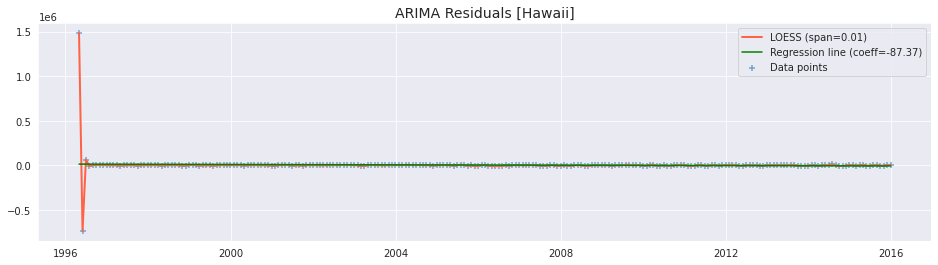

In [217]:
arima_resid = pd.Series(result_ARIMA_auto.resid, index =data_train.index)
plotTS(pd.DataFrame(arima_resid, columns=['resid']), column='resid', figsize=(16,4), title='ARIMA Residuals [Hawaii]')

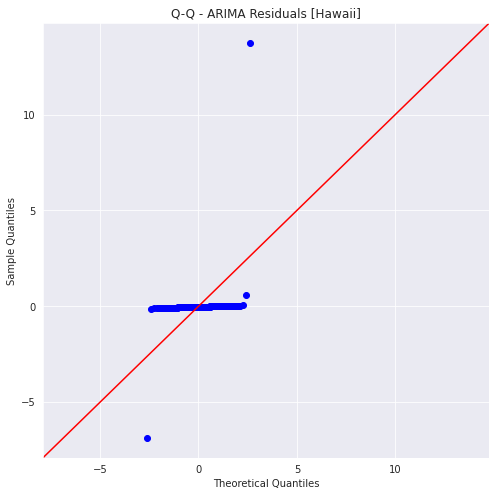

*** Shapiro-Wilk Test ***
W:  0.08918631076812744
p-value:  3.880793212852024e-32
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  247328.14724582576
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  429.85655417181454
p-value:  4.548154996865321e-94
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  9.592615367867081
Kurtosis :  157.09174150892795


In [218]:
qqPlot(arima_resid, title='- ARIMA Residuals [Hawaii]')
checkNormality(arima_resid)

In [219]:
checkStationarity(arima_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -5.240391364346942
p-value:  7.267486940041408e-06
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.2928041589452749
p-value:  0.1
Interpretation: The time series is stationary (Ho)


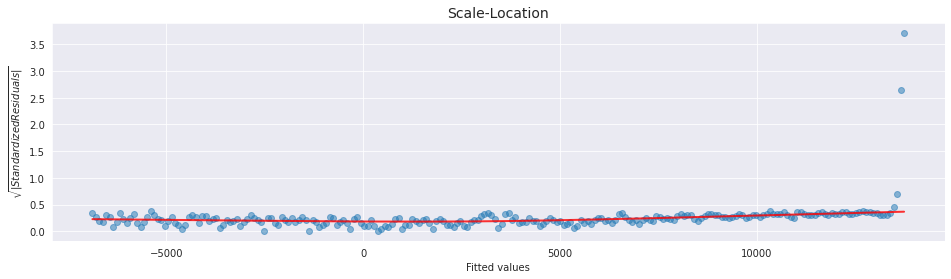

*** Koenker Test ***
Lagrange multiplier statistic:  4.461041544728642
p-value:  0.034676347762482046
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [220]:
scalelocationPlot(arima_resid, figsize=(16,4))
checkHomoscedasticity(arima_resid, robust=True)

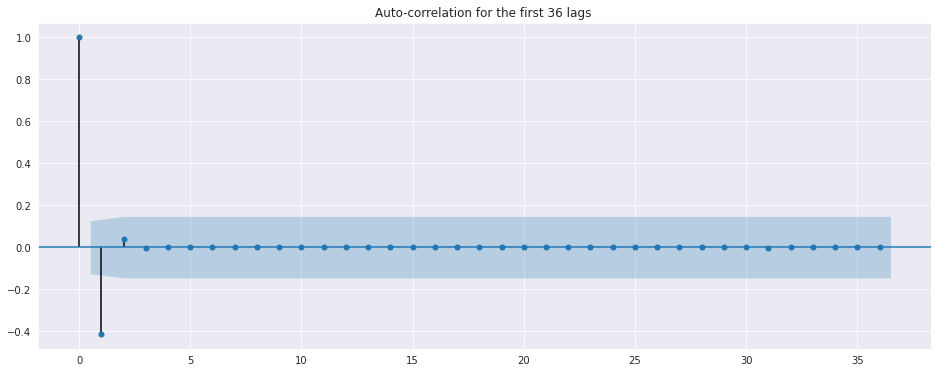

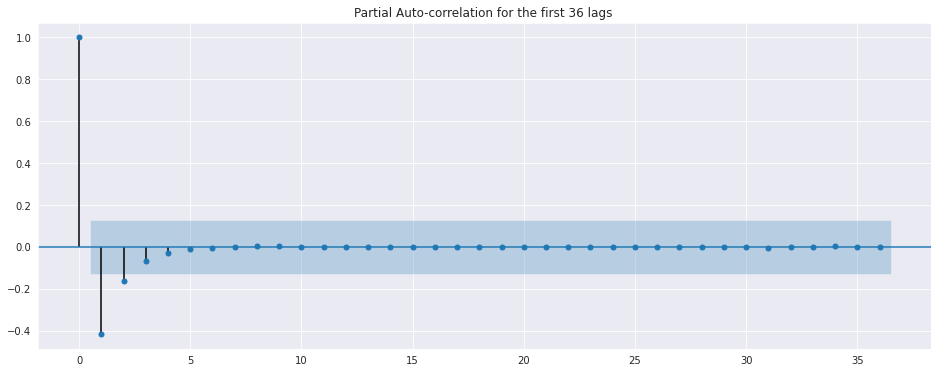

*** Ljung-Box Test [36 lags] ***
Q:  41.484659142852934
p-value:  0.24386928523741305
Interpretation: the residuals are independently distributed (Ho)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  46.553151973366994
p-value:  0.11191644393568559
Interpretation: there is no autocorrelation at any order less than or equal to p (Ho)


In [221]:
autocorrelationPlot(arima_resid, lags=36)
checkAutorcorrelation(arima_resid, lags=36)

In [222]:
y_pred_arima = arima_model.predict(n_periods=24)
y_pred_arima = pd.Series(y_pred_arima)
y_pred_arima.index = data_test.index

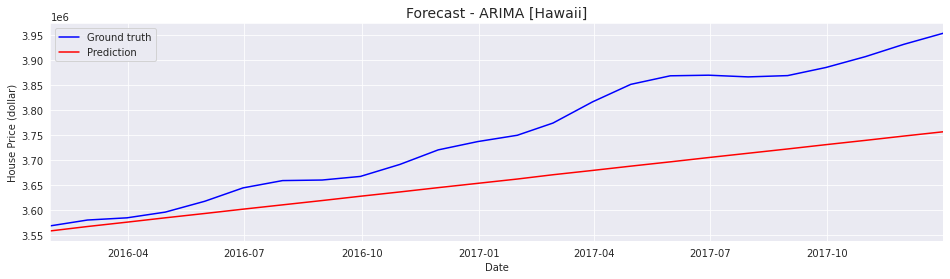

In [223]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_arima, color='red', label='Prediction')
plt.title('Forecast - ARIMA [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House Price (dollar)')
plt.legend()
plt.show()

In [224]:
mse_arima = mean_squared_error(y_pred_arima,data_test.values)
mae_arima = mean_absolute_error(y_pred_arima,data_test.values)
mape_arima = mean_absolute_percentage_error(y_pred_arima,data_test.values)*100

print('ARIMA model performance: ')
print('MSE: ', round(mse_arima,3))
print('MAE: ', round(mae_arima,3))
print('MAPE: ', round(mape_arima,3), '%')

ARIMA model performance: 
MSE:  13052313001.723
MAE:  95030.001
MAPE:  2.571 %


#Prophet

In [225]:
from prophet import Prophet

In [253]:
train_prophet = pd.DataFrame({'y':data_train.values,'ds':data_train.index.to_list()})
prophet_model = Prophet(daily_seasonality=False, weekly_seasonality=False,yearly_seasonality=True)
prophet_fitted_model = prophet_model.fit(train_prophet)
future = prophet_fitted_model.make_future_dataframe(periods = 24)
forecast = prophet_fitted_model.predict(future)

DEBUG:cmdstanpy:input tempfile: /tmp/tmp5lwgl1vc/3h79t28c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp5lwgl1vc/mkr6oxs3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33028', 'data', 'file=/tmp/tmp5lwgl1vc/3h79t28c.json', 'init=/tmp/tmp5lwgl1vc/mkr6oxs3.json', 'output', 'file=/tmp/tmp5lwgl1vc/prophet_modeld0fe6zbl/prophet_model-20230203232613.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:26:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:26:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


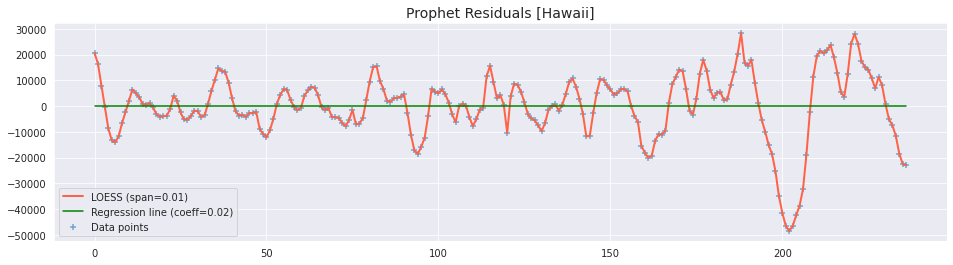

In [254]:
tmp = pd.merge(train_prophet, forecast.head(len(forecast)-24), on='ds')
prophet_resid = tmp['y'] - tmp['yhat']
plotTS(pd.DataFrame(prophet_resid, columns=['resid']), column='resid', figsize=(16,4), title='Prophet Residuals [Hawaii]')

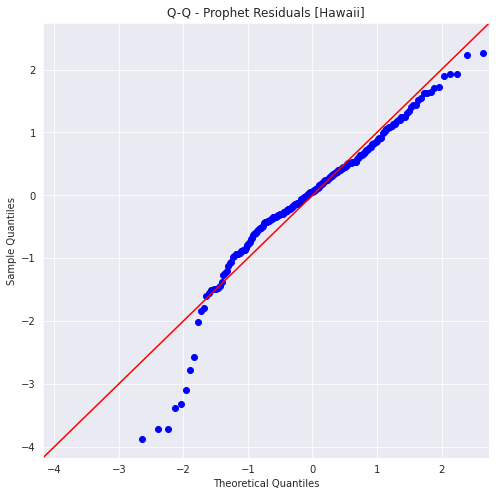

*** Shapiro-Wilk Test ***
W:  0.9338152408599854
p-value:  7.658867318127704e-09
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  115.40707971234718
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  52.472935946744286
p-value:  4.03317191700474e-12
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -1.0519142869170848
Kurtosis :  2.6945682797401656


In [228]:
qqPlot(prophet_resid, title='- Prophet Residuals [Hawaii]')
checkNormality(prophet_resid)

In [229]:
checkStationarity(prophet_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -5.287822347355221
p-value:  5.8028182103944585e-06
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.02245320831810333
p-value:  0.1
Interpretation: The time series is stationary (Ho)


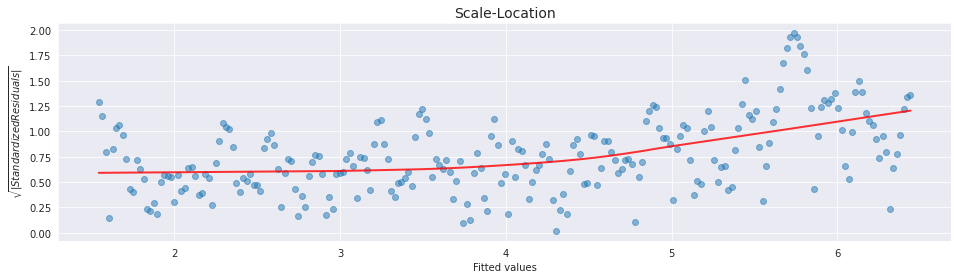

*** Koenker Test ***
Lagrange multiplier statistic:  34.466333397710756
p-value:  4.336881329587007e-09
Interpretation: Heteroscedasticity is present, the residuals are not distributed with equal variance (Ha)


In [230]:
scalelocationPlot(prophet_resid, figsize=(16,4))
checkHomoscedasticity(prophet_resid, robust=True)

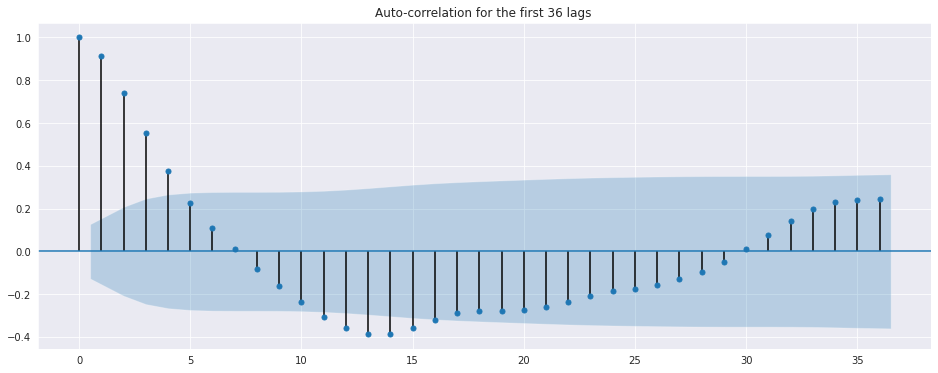

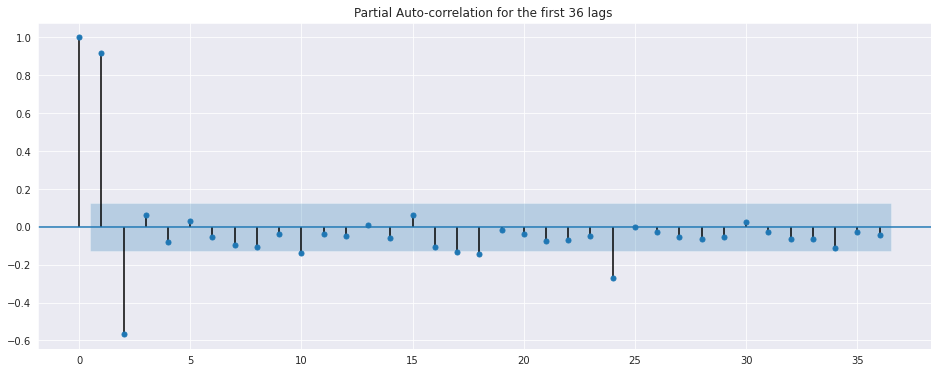

*** Ljung-Box Test [36 lags] ***
Q:  890.4468655626191
p-value:  1.3600196040441893e-163
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  217.0847860682138
p-value:  9.724732359096311e-28
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [231]:
autocorrelationPlot(prophet_resid, lags=36)
checkAutorcorrelation(prophet_resid, lags=36)

In [232]:
y_pred_prophet = forecast['yhat'].tail(24)
y_pred_prophet.index = data_test.index

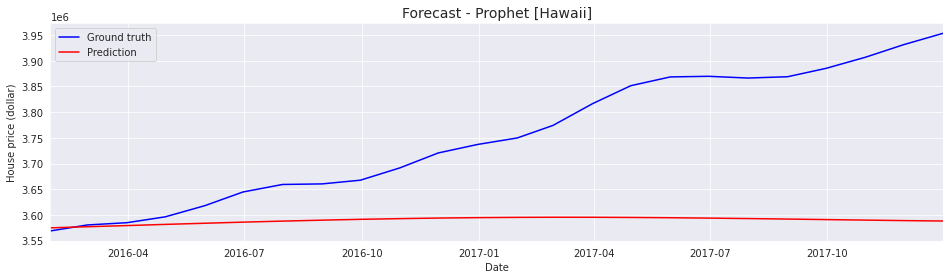

In [233]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_prophet, color='red', label='Prediction')
plt.title('Forecast - Prophet [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [234]:
mse_prophet = mean_squared_error(y_pred_prophet,data_test.values)
mae_prophet = mean_absolute_error(y_pred_prophet,data_test.values)
mape_prophet = mean_absolute_percentage_error(y_pred_prophet,data_test.values)*100

print('Prophet model performance: ')
print('MSE: ', round(mse_prophet,3))
print('MAE: ', round(mae_prophet,3))
print('MAPE: ', round(mape_prophet,3), '%')

Prophet model performance: 
MSE:  40747596672.544
MAE:  164121.324
MAPE:  4.569 %


# Triple Exponential Smoothing (Holt-Winters method)

In [235]:
# Triple Exponential Smoothing (Holt-Winters method)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [236]:
# Fit = multiplicative trend, additive seasonal of period season_length = 36
holtwinters_fitted_model = ExponentialSmoothing(data_train,seasonal_periods=36,trend='mul',seasonal='add').fit()

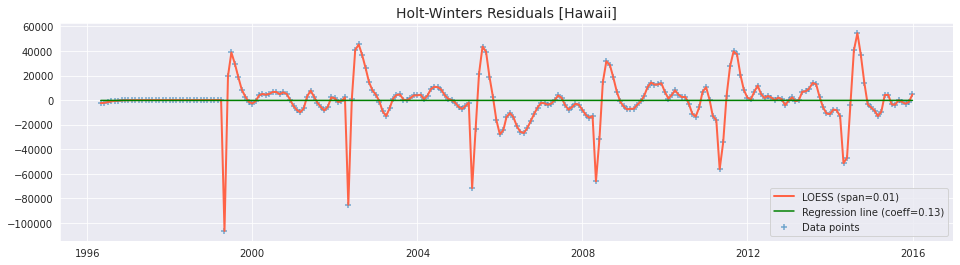

In [237]:
holtwinters_resid = pd.Series(holtwinters_fitted_model.resid, index =data_train.index)
plotTS(pd.DataFrame(holtwinters_resid, columns=['resid']), column='resid', figsize=(16,4), title='Holt-Winters Residuals [Hawaii]')

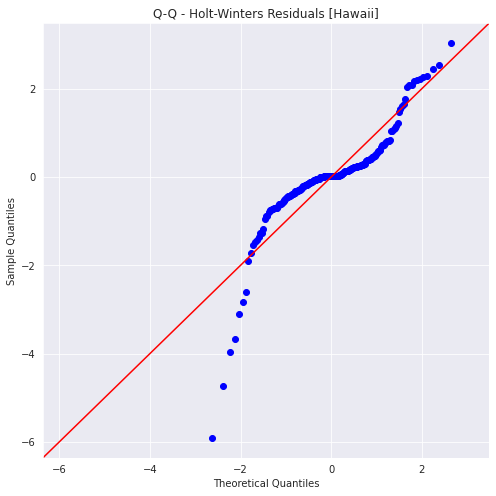

*** Shapiro-Wilk Test ***
W:  0.8054792881011963
p-value:  1.6799462523245655e-16
Interpretation: the data was not drawn from a normal distribution (Ha)

*** Jarque-Bera Test ***
Jarque-Bera JB:  855.6770024458066
p-value:  0.0
Interpretation: the data was not drawn from a normal distribution (Ha)

*** D’Agostino-Pearson Test ***
k2:  103.97406897001676
p-value:  2.644343033302363e-23
Interpretation: the data was not drawn from a normal distribution (Ha)

----------------------------------------------------------------------
Skewness:  -1.5002454864184243
Kurtosis :  8.811803993090132


In [238]:
qqPlot(holtwinters_resid, title='- Holt-Winters Residuals [Hawaii]')
checkNormality(holtwinters_resid)

In [239]:
checkStationarity(holtwinters_resid, kpss_type='c')

*** ADF Test ***
ADF Statistic:  -8.589285664077957
p-value:  7.360716769749804e-14
Interpretation: The time series is stationary (Ha)

*** KPSS Test ***
KPSS Statistic: 0.08071421915199728
p-value:  0.1
Interpretation: The time series is stationary (Ho)


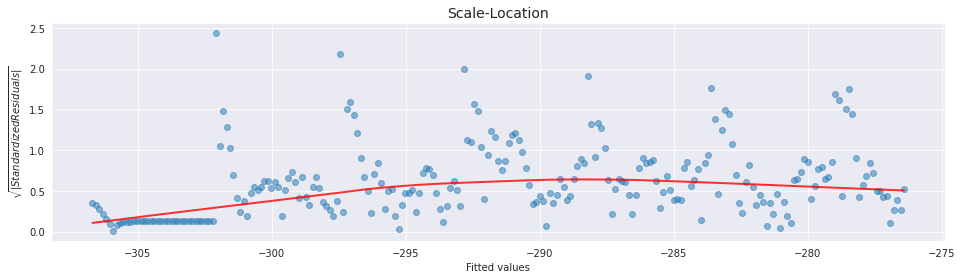

*** Koenker Test ***
Lagrange multiplier statistic:  0.05096846316113468
p-value:  0.8213865637695577
Interpretation: Homoscedasticity is present, the residuals are distributed with equal variance (Ho)


In [240]:
scalelocationPlot(holtwinters_resid, figsize=(16,4))
checkHomoscedasticity(holtwinters_resid, robust=True)

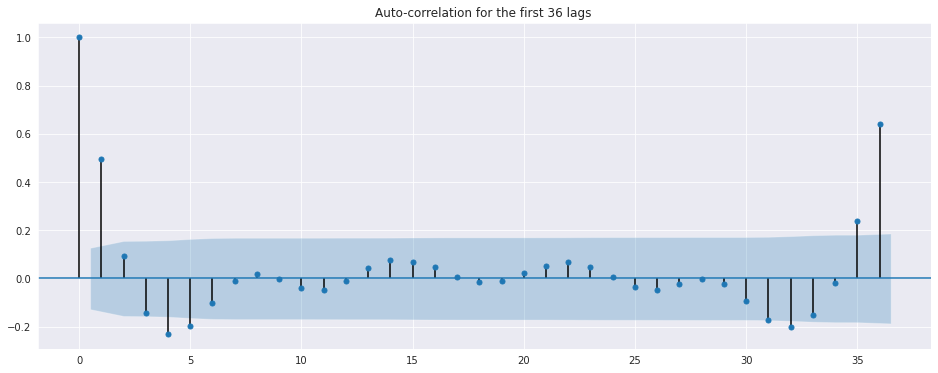

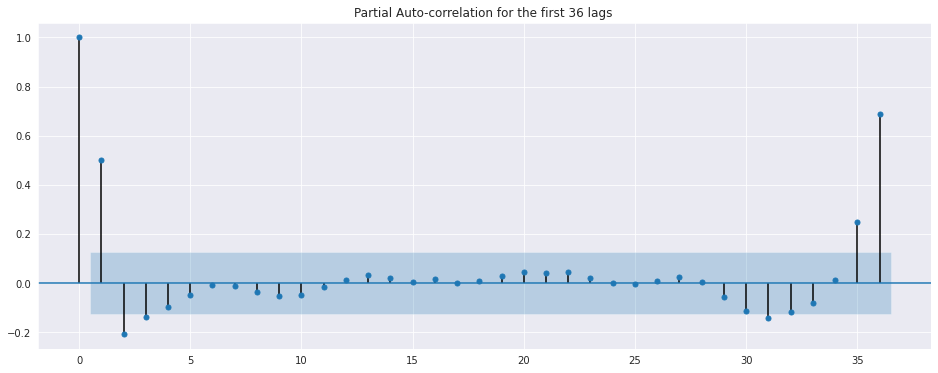

*** Ljung-Box Test [36 lags] ***
Q:  261.0412237867308
p-value:  6.182124638976311e-36
Interpretation: The residuals are not independently distributed, they exhibit serial correlation (Ha)

*** Breusch-Godfrey Test [36 lags] ***
Lagrange multiplier statistic:  146.8365566321982
p-value:  2.4809585245628774e-15
Interpretation: There exists autocorrelation at some order less than or equal to p (Ha)


In [241]:
autocorrelationPlot(holtwinters_resid, lags=36)
checkAutorcorrelation(holtwinters_resid, lags=36)

In [242]:
# Predictions
y_pred_holtwinters = holtwinters_fitted_model.forecast(24)
y_pred_holtwinters = pd.Series(y_pred_holtwinters, index=data_test.index)

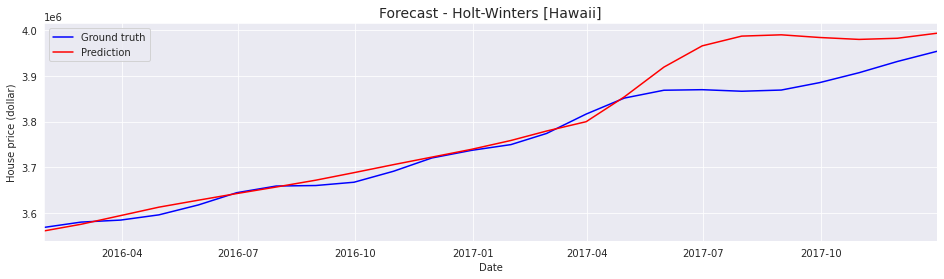

In [243]:
plt.figure(figsize=(16,4))
plt.plot(data_test, color='blue', label='Ground truth')
plt.plot(y_pred_holtwinters, color='red', label='Prediction')
plt.title('Forecast - Holt-Winters [Hawaii]', fontsize=14)
plt.xlim(data_test.index[0],data_test.index[-1])
plt.xlabel('Date')
plt.ylabel('House price (dollar)')
plt.legend()
plt.show()

In [244]:
mse_holtwinters = mean_squared_error(y_pred_holtwinters,data_test.values)
mae_holtwinters = mean_absolute_error(y_pred_holtwinters,data_test.values)
mape_holtwinters = mean_absolute_percentage_error(y_pred_holtwinters,data_test.values)*100

print('Holt-Winters model performance: ')
print('MSE: ', round(mse_holtwinters,3))
print('MAE: ', round(mae_holtwinters,3))
print('MAPE: ', round(mape_holtwinters,3), '%')

Holt-Winters model performance: 
MSE:  2572051109.535
MAE:  32805.513
MAPE:  0.836 %


#Summery

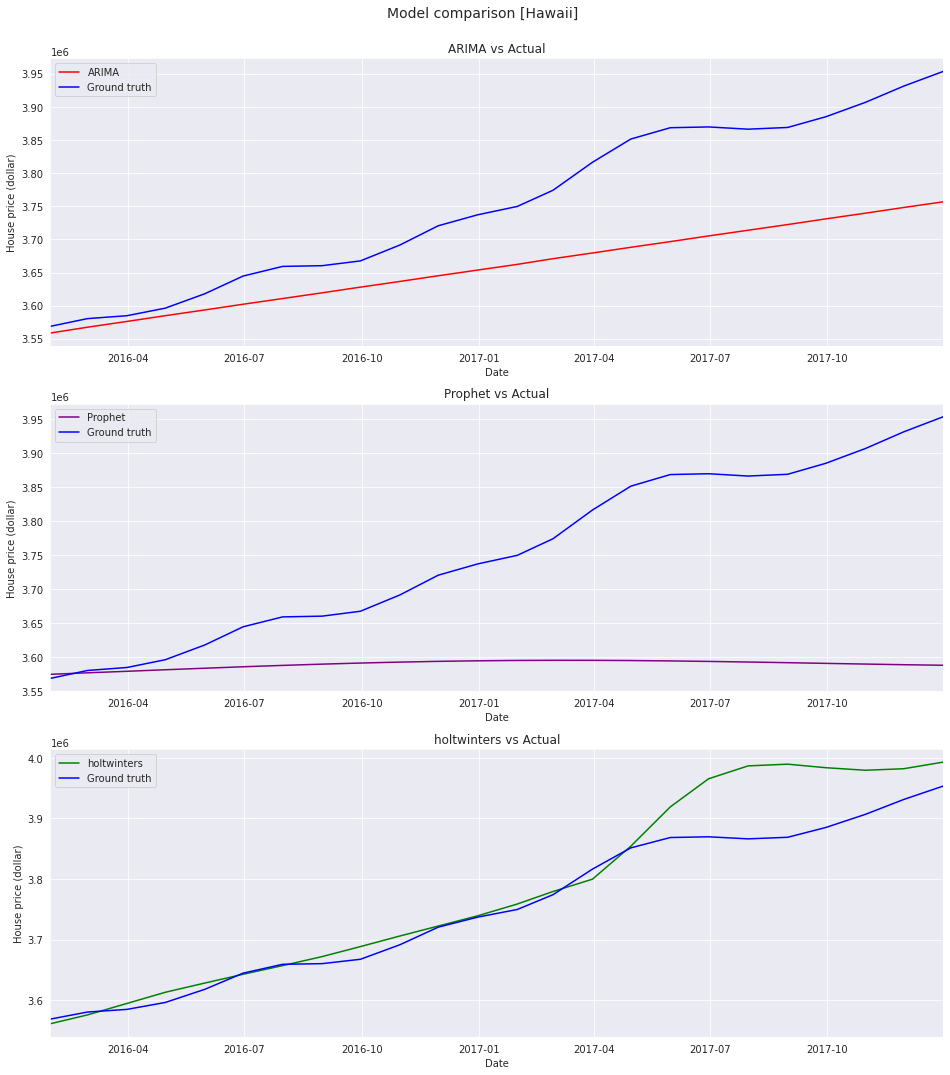

In [245]:
f, axes = plt.subplots(3,1,figsize=(16,18))
plt.suptitle('Model comparison [Hawaii]', y=0.92, fontsize=14)

axes[0].plot(y_pred_arima, color='red', label='ARIMA')
axes[0].plot(data_test, color='blue', label='Ground truth')
axes[0].set_title('ARIMA vs Actual', fontdict={'fontsize': 12})

axes[1].plot(y_pred_prophet, color='purple', label='Prophet')
axes[1].plot(data_test, color='blue', label='Ground truth')
axes[1].set_title('Prophet vs Actual', fontdict={'fontsize': 12})

axes[2].plot(y_pred_holtwinters, color='green', label='holtwinters')
axes[2].plot(data_test, color='blue', label='Ground truth')
axes[2].set_title('holtwinters vs Actual', fontdict={'fontsize': 12})

for a in axes:
    a.set_ylabel('House price (dollar)')
    a.set_xlabel('Date')
    a.set_xlim(data_test.index[0], data_test.index[-1])
    a.legend()

plt.show()

In [246]:
data = {'Model':['ARIMA','PROPHET','HOLT WINTERS'],
        'MSE':[mse_arima, mse_prophet, mse_holtwinters],
        'MAE':[mae_arima, mae_prophet, mae_holtwinters],
        'MAPE (%)':[mape_arima, mape_prophet, mape_holtwinters],
        'Stationarity (residuals)':['Stationary','Stationary','Stationary'],
        'Distribution (residuals)':['Not normal','Not normal','Not normal'],
        'Homoscedasticity (residuals)':['Homoscedastic','Heteroscedastic','Heteroscedastic'],
        'Autocorrelation (residuals)':['Autocorrelated','Autocorrelated','Autocorrelated']}

all_models_summary = pd.DataFrame(data)
display(round(all_models_summary,3))

,Model,MSE,MAE,MAPE (%),Stationarity (residuals),Distribution (residuals),Homoscedasticity (residuals),Autocorrelation (residuals)
0,ARIMA,1.305231e+10,95030.001,2.571,Stationary,Not normal,Homoscedastic,Autocorrelated
1,PROPHET,4.074760e+10,164121.324,4.569,Stationary,Not normal,Heteroscedastic,Autocorrelated
2,HOLT WINTERS,2.572051e+09,32805.513,0.836,Stationary,Not normal,Heteroscedastic,Autocorrelated


#Forcasting